In [1]:
# --- Standard Library ---
import os, math, re, glob, json, random, hashlib, textwrap, urllib.request
from io import BytesIO
from pathlib import Path
from typing import List, Optional, Dict
from collections import Counter
from urllib.parse import urljoin, urlparse
from urllib import robotparser
import xml.etree.ElementTree as ET
import warnings

# --- Data Manipulation & Analysis ---
import numpy as np
import pandas as pd
import geopandas as gpd

# --- Web Scraping & API ---
import requests
from bs4 import BeautifulSoup
from PIL import Image

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Interactive Widgets ---
from ipywidgets import (
    HBox, VBox, Label, IntSlider,
    fixed, interact, interact_manual, interactive_output
)

# --- Machine Learning: Preprocessing & Clustering ---
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Machine Learning: Models & Evaluation ---
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap

# --- Statistics ---
from scipy import stats


In [2]:
HyperRisk_kaggle = pd.read_csv("https://gayathiri-ravendirane.emi.u-bordeaux.fr/DATA/HyperRisk_kaggle.csv")
print(HyperRisk_kaggle.shape)
HyperRisk_kaggle.head()

BloodPressure_kaggle = pd.read_csv("https://gayathiri-ravendirane.emi.u-bordeaux.fr/DATA/BloodPressure_kaggle.csv")
print(BloodPressure_kaggle.shape)
BloodPressure_kaggle.head()

BloodValues_kaggle = pd.read_excel("https://gayathiri-ravendirane.emi.u-bordeaux.fr/DATA/BloodValues_kaggle.xlsx")
print(BloodValues_kaggle.shape)
BloodValues_kaggle.head()

BloodDonation_kaggle = pd.read_csv("https://melissa-aftisse.emi.u-bordeaux.fr/DATA/blood_donation.csv")
print(BloodDonation_kaggle.shape)
BloodDonation_kaggle.head()

(4240, 13)
(2000, 15)
(4598, 14)
(10000, 18)


,Donor_ID,Full_Name,Gender,Age,Blood_Group,Contact_Number,Email,City,State,Country,Last_Donation_Date,Total_Donations,Eligible_for_Donation,Medical_Condition,Weight_kg,Hemoglobin_g_dL,Donation_Center,Registration_Date
0,DNR000001,Sangeeta Menon,Female,38,O+,1819600042,sangeeta.menon8280@gmail.com,Kolkata,West Bengal,India,07-10-2025,1,Yes,NaN,66.6,13.6,Red Cross Blood Bank,02-07-2021
1,DNR000002,Meena Iyer,Female,49,B+,265423420,meena.iyer6225@gmail.com,Jaipur,Rajasthan,India,08-11-2020,1,No,Hypertension,70.8,14.0,Metro Blood Bank,03-03-2023
2,DNR000003,Priya Nair,Female,29,B+,1849593012,priya.nair4742@gmail.com,Gurgaon,Haryana,India,12-04-2025,2,No,Diabetes,73.4,12.5,Fortis Blood Bank,15-10-2015
3,DNR000004,Vijay Kapoor,Male,29,O+,3419283185,vijay.kapoor4423@gmail.com,Thiruvananthapuram,Kerala,India,21-02-2025,1,Yes,NaN,57.9,14.8,NABL Blood Centre,09-05-2022
4,DNR000005,Rahul Iyer,Male,27,A+,6413953676,rahul.iyer2341@gmail.com,Bhopal,Madhya Pradesh,India,18-04-2024,1,Yes,NaN,74.0,17.1,NABL Blood Centre,13-07-2022


In [3]:
df = HyperRisk_kaggle.copy()

# ================= Missing values =================
num_vars = ["glucose", "totChol", "BMI", "heartRate", "cigsPerDay"]

for col in num_vars:
  if col in df.columns:
    df[col] = df[col].fillna(df[col].median())

if "BPMeds" in df.columns:
  df["BPMeds"] = df["BPMeds"].fillna(0)

df = df[df.isnull().sum(axis=1) < 3]

# ================= Outliers (winsorization) =================
def winsorize(series):
  low = series.quantile(0.01)
  high = series.quantile(0.99)
  return series.clip(low, high)

df["is_outlier"] = 0
for col in num_vars:
  if col in df.columns:
    before = df[col].copy()
    df[col] = winsorize(df[col])
    df.loc[before != df[col], "is_outlier"] = 1

# ================= Physiological bounds =================
bounds = {
  "glucose": (50, 400),
  "totChol": (100, 400),
  "BMI": (15, 60),
  "heartRate": (40, 200),
  "cigsPerDay": (0, 100)
}

for col, (low, high) in bounds.items():
  if col in df.columns:
    df = df[(df[col] >= low) & (df[col] <= high)]

# ================= Normalization =================
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

# ================= Remove duplicates (key columns) =================
dup_cols = ["age", "sex", "glucose", "BMI"]
dup_cols = [c for c in dup_cols if c in df.columns]

df = df.drop_duplicates(subset=dup_cols, keep="first")

HyperRisk_kaggle = df

print("Final shape:", df.shape)
print(df.head())

Final shape: (4231, 14)
   male  age  currentSmoker  cigsPerDay  BPMeds  diabetes   totChol  sysBP  \
0     1   39              0   -0.760321     0.0         0 -0.977089  106.0   
1     0   46              0   -0.760321     0.0         0  0.322360  121.0   
2     1   48              1    0.951622     0.0         0  0.204229  127.5   
3     0   61              1    1.807594     0.0         0 -0.268298  150.0   
4     0   46              1    1.208414     0.0         0  1.149282  130.0   

   diaBP       BMI  heartRate   glucose  Risk  is_outlier  
0   70.0  0.302981   0.353571 -0.237800     0           0  
1   81.0  0.750371   1.629147 -0.300239     0           0  
2   80.0 -0.111362  -0.071621 -0.674875     0           0  
3   95.0  0.712241  -0.922005  1.385623     1           0  
4   84.0 -0.680768   0.778763  0.261715     0           0  


In [4]:
def _mad_outliers(s, k=3.5):
    s = s.dropna()
    if s.empty:
        return s.iloc[0:0]
    med = s.median()
    mad = np.median(np.abs(s - med))
    if mad == 0:
        return s.iloc[0:0]
    z = np.abs(s - med) / (1.4826 * mad)
    return s[z > k]

def mixed_outlier_detector(series):
    name = str(getattr(series, 'name', '')).strip()
    if name == 'salt_content_in_the_diet':
        return _mad_outliers(series, k=3.5)
    # Default IQR-based detection
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]        

def cap_iqr(s):
  q1,q3=s.quantile(0.25),s.quantile(0.75);iqr=q3-q1
  return s.clip(q1-1.5*iqr,q3+1.5*iqr)   

In [5]:
df=BloodPressure_kaggle.copy()

# ================= Missing values =================
required_cols = {"Sex", "Pregnancy"}
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print(f"Colonnes manquantes: {missing}")
else:
    before_inconsistent = int(((df["Sex"] == 0) & (df["Pregnancy"] != 0)).sum())
    df.loc[df["Sex"] == 0, "Pregnancy"] = 0

    after_inconsistent = int(((df["Sex"] == 0) & (df["Pregnancy"] != 0)).sum())

    print(f"Incohérences (Sex=0 & Pregnancy>0) avant correction: {before_inconsistent}")
    print(f"Incohérences (Sex=0 & Pregnancy>0) après correction:  {after_inconsistent}")

print(f"Valeurs manquantes = {df['Pregnancy'].isna().sum()}")

df.drop(columns=["Pregnancy","Patient_Number"],errors="ignore",inplace=True)

num_cols=["Level_of_Hemoglobin","Genetic_Pedigree_Coefficient",
          "alcohol_consumption_per_day","salt_content_in_the_diet",
          "Age","BMI","Level_of_Stress"]

df[num_cols]=df[num_cols].apply(lambda c:c.fillna(c.median()))

# ================= Outliers (winsorization) =================
df["Level_of_Hemoglobin"]=cap_iqr(df["Level_of_Hemoglobin"])

# ================= Normalization =================
df["salt_content_in_the_diet"]=np.log1p(df["salt_content_in_the_diet"])

# ================= Physiological bounds =================
df=df[(df["Age"]>0)&(df["BMI"]>0)&(df["alcohol_consumption_per_day"]>=0)]

BloodPressure_kaggle = df
print("Final shape:", df.shape)


Incohérences (Sex=0 & Pregnancy>0) avant correction: 1008
Incohérences (Sex=0 & Pregnancy>0) après correction:  0
Valeurs manquantes = 550
Final shape: (2000, 13)


In [6]:

bio_cols = [
  "Glucose (fasting)",
  "ALT (Alanin Aminotransferaz)",
  "AST (Aspartat Aminotransferaz)",
  "Creatinine",
  "Thyroid Stimulating Hormone (TSH)",
  "Triglyceride",
  "blood urea nitrogen - [ÜRE]",
  "blood urea nitrogen (BUN)",
  "Free T4 (FT4)",
  "High Density Lipoprotein (HDL Cholesterol)",
  "Cholesterol",
  "Low Density Lipoprotein (LDL Cholesterol)"
]

BloodValues_kaggle[bio_cols] = BloodValues_kaggle[bio_cols].apply(
  lambda c: c.where(c >= 0)
)

def winsorize(series, low, high):
  ql, qh = series.quantile([low, high])
  return series.clip(ql, qh)

for col in bio_cols:
  BloodValues_kaggle[col] = winsorize(
    BloodValues_kaggle[col], 0.01, 0.99
  )

BloodValues_kaggle["Glucose (fasting)"] = np.log1p(
  BloodValues_kaggle["Glucose (fasting)"]
)

skewed_cols = [
  "Triglyceride",
  "ALT (Alanin Aminotransferaz)",
  "AST (Aspartat Aminotransferaz)",
  "blood urea nitrogen (BUN)"
]

for col in skewed_cols:
  BloodValues_kaggle[col] = np.log1p(BloodValues_kaggle[col])

print(BloodValues_kaggle.shape)
BloodValues_kaggle.head()



(4598, 14)


,"Gender (0:Female, 1: Male)",Age,Glucose (fasting),AST (Aspartat Aminotransferaz),ALT (Alanin Aminotransferaz),Creatinine,blood urea nitrogen (BUN),blood urea nitrogen - [ÜRE],Thyroid Stimulating Hormone (TSH),Triglyceride,Cholesterol,High Density Lipoprotein (HDL Cholesterol),Low Density Lipoprotein (LDL Cholesterol),Free T4 (FT4)
0,0,59,4.510860,2.708050,2.564949,0.81,2.484907,23.54,0.979,4.700480,196,67.3,107.0,1.590
1,0,69,4.976734,2.995732,2.708050,0.75,2.833213,34.24,2.420,4.682131,178,46.1,111.0,0.935
2,0,63,5.752573,2.484907,2.890372,0.86,2.564949,25.68,7.690,6.095825,188,51.4,77.0,1.320
3,0,63,5.433722,2.302585,2.890372,0.81,3.091042,44.94,3.860,5.087596,248,42.2,174.0,1.280
4,1,66,4.584967,2.944439,3.091042,0.98,3.218876,51.36,0.414,4.442651,164,41.1,106.0,1.290


In [7]:
df = BloodDonation_kaggle

# ================= Missing values =================
df.drop(columns=["Donor_ID","Full_Name","Email","Contact_Number","Last_Donation_Date",
                 "Donation_Center","Medical_Condition"], inplace=True)
print("After dropping unused columns:", df.shape)
if (sum(BloodDonation_kaggle['Country'] != 'India') == 0):
  df.drop(columns=["Country"], inplace=True)
print("After dropping Country column if only India:", df.shape)

# ================= Encoding =================
df["Gender"] = df["Gender"].map({"Male":1, "Female":0})
print("After mapping Gender:", df.shape)
df["Eligible_for_Donation"] = df["Eligible_for_Donation"].map({"Yes":1, "No":0})
print("After mapping Eligible_for_Donation:", df.shape)
df["Registration_Date"] = pd.to_datetime(df["Registration_Date"], dayfirst=True, errors="coerce")

# ================= Physiological bounds =================
df = df[(df["Age"].between(18,65)) & (df["Weight_kg"].between(40,150))]
print("After filtering Age and Weight_kg:", df.shape)
df = df[df["Hemoglobin_g_dL"].between(10,20)]
print("After filtering Hemoglobin_g_dL:", df.shape)

# ================= Outliers (winsorization) =================
for c in ["Age","Total_Donations","Weight_kg","Hemoglobin_g_dL"]:
  df[c] = cap_iqr(df[c])
print("After capping IQR on numeric columns:", df.shape)  

# ================= Encoding / Feature engineering =================
df = pd.get_dummies(df, columns=["Blood_Group"], drop_first=True)
print("After one-hot encoding Blood_Group:", df.shape)

# ================= Data consistency checks =================
invalid_gender = BloodDonation_kaggle[~BloodDonation_kaggle['Gender'].isin([0, 1])]
print(f"Invalid Gender entries: {len(invalid_gender)}")
if len(invalid_gender) > 0:
  df = df[df['Gender'].isin([0, 1])]
print("After filtering invalid Gender entries:", df.shape)

BloodDonation_kaggle = df
print(BloodDonation_kaggle.shape)

After dropping unused columns: (10000, 11)
After dropping Country column if only India: (10000, 10)
After mapping Gender: (10000, 10)
After mapping Eligible_for_Donation: (10000, 10)
After filtering Age and Weight_kg: (10000, 10)
After filtering Hemoglobin_g_dL: (10000, 10)
After capping IQR on numeric columns: (10000, 10)
After one-hot encoding Blood_Group: (10000, 16)
Invalid Gender entries: 108
After filtering invalid Gender entries: (9892, 16)
(9892, 16)


# Prédiction du Risque de Don

**📊 Datasets utilisés :** 1 (`HyperRisk_kaggle`) + 2 (`BloodPressure_kaggle`) + 3 (`BloodValues_kaggle`) + 5 (`BloodDonation_kaggle`)

**Visualisations :**
- Feature importance plots (Random Forest, XGBoost)
- SHAP values pour l'interprétabilité
- Confusion matrix et ROC curves
- Calibration plots

**Tests statistiques :**
- Régression logistique (odds ratios)
- Tests de significativité des coefficients

In [8]:
# -------------------------------
# Merge datasets 1 + 2 + 3
# -------------------------------
df = HyperRisk_kaggle.copy()
df = df.merge(BloodPressure_kaggle, left_on=["age","male"], right_on=["Age","Sex"], how="left")
df = df.merge(BloodValues_kaggle, left_on=["age","male"], right_on=["Age","Gender (0:Female, 1: Male)"], how="left")


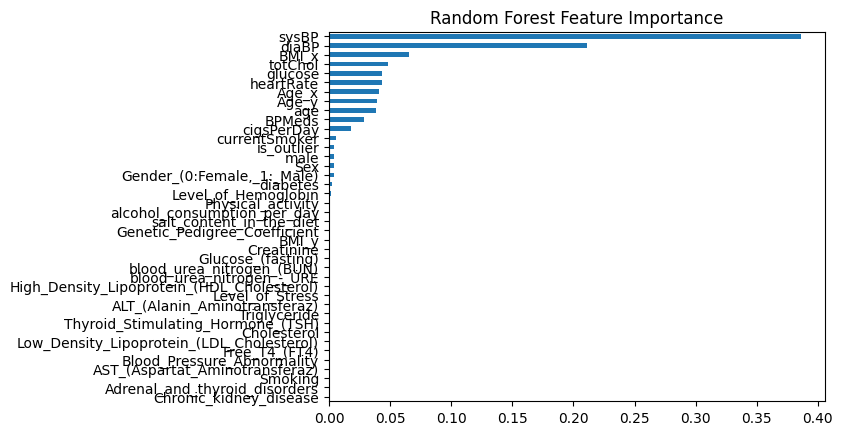

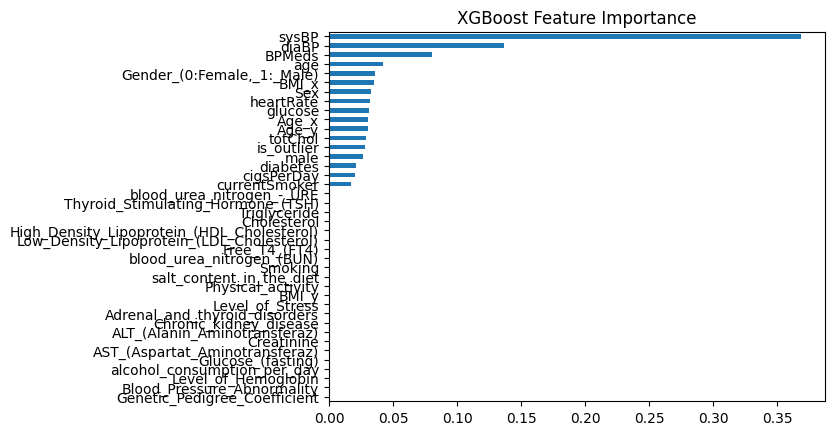

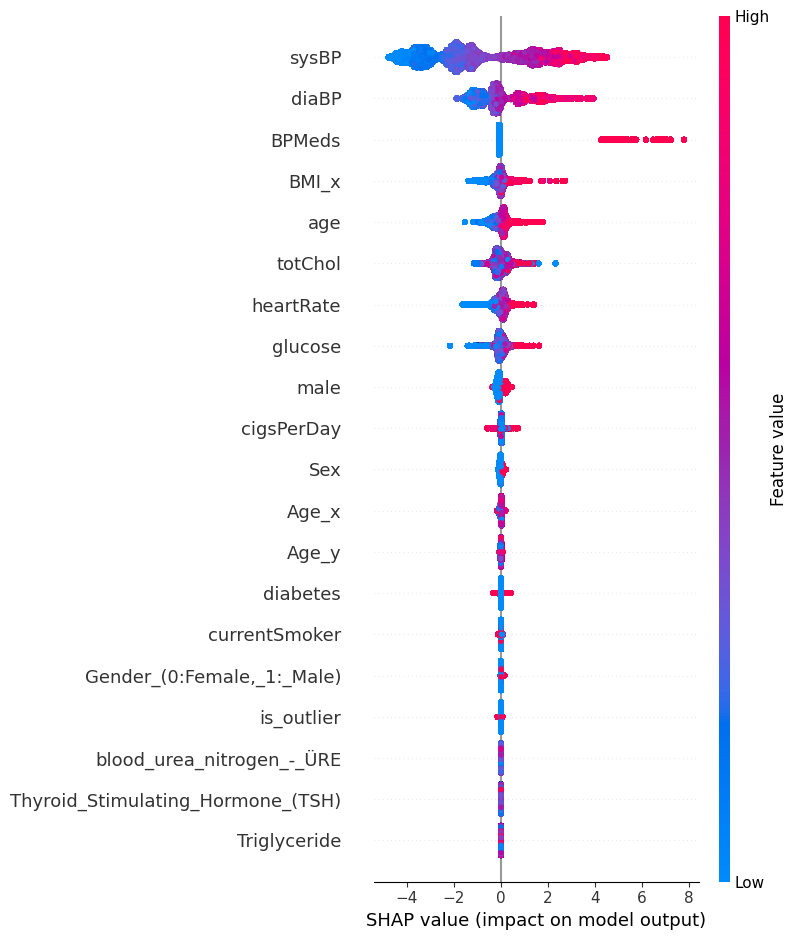

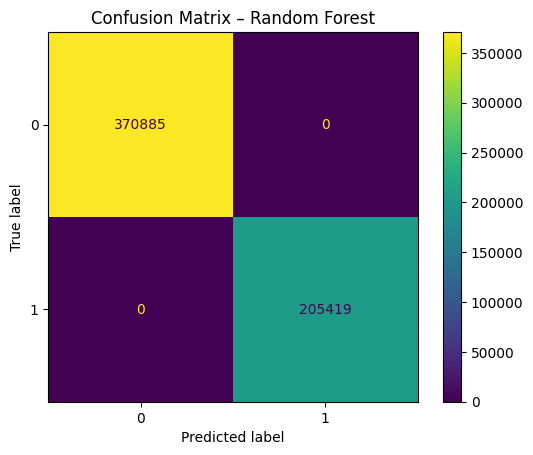

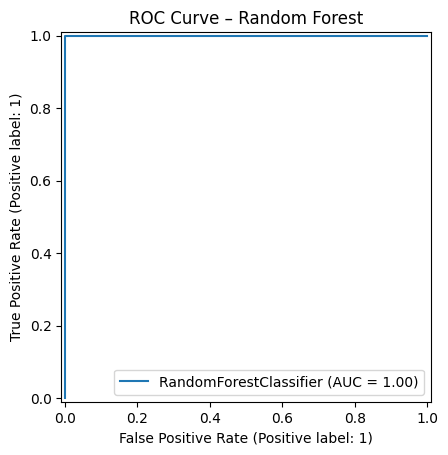

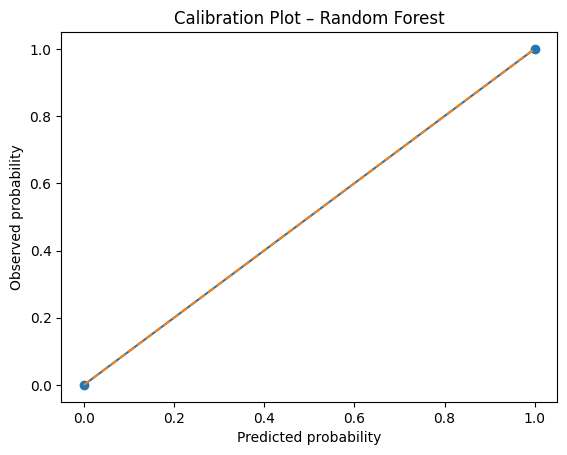

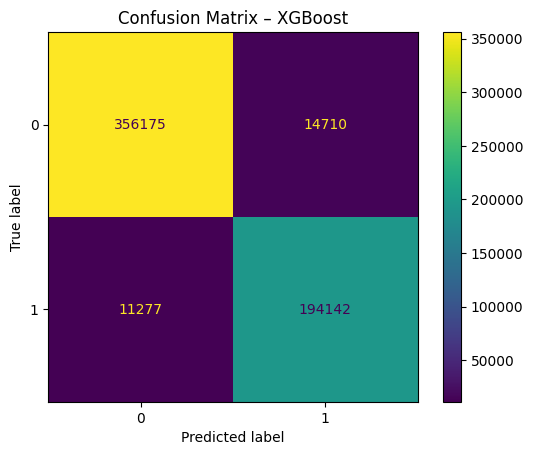

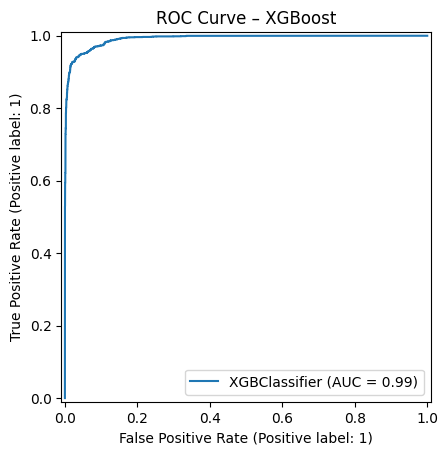

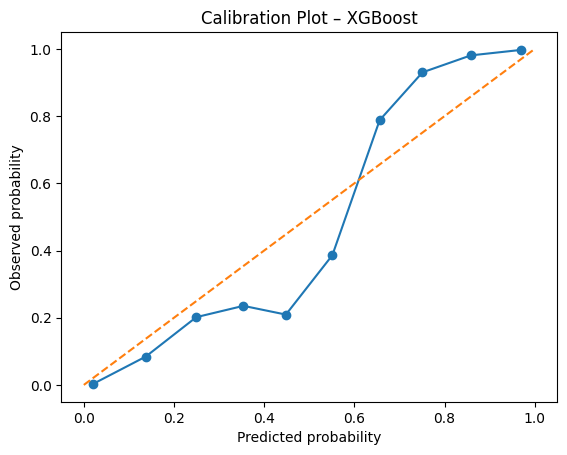

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

# -------------------------------
# Prepare data
# -------------------------------
df = HyperRisk_kaggle.copy()
df = df.merge(BloodPressure_kaggle, left_on=["age","male"], right_on=["Age","Sex"], how="left")
df = df.merge(BloodValues_kaggle, left_on=["age","male"], right_on=["Age","Gender (0:Female, 1: Male)"], how="left")

X = df.drop(columns=["Risk"])
y = df["Risk"]

# clean column names for XGBoost / SHAP
X = X.rename(columns=lambda x: x.strip().replace(" ","_").replace("[","").replace("]","").replace("<","").replace(">",""))

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------
# Train models
# -------------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(
  n_estimators=300, max_depth=4, learning_rate=0.05,
  subsample=0.8, colsample_bytree=0.8,
  eval_metric="logloss", random_state=42
)
xgb_model.fit(X_train, y_train)

# -------------------------------
# Feature importance
# -------------------------------
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(
  kind="barh", title="Random Forest Feature Importance"
)
plt.savefig("rf_feature_importance.png")
plt.show()

pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values().plot(
  kind="barh", title="XGBoost Feature Importance"
)
plt.savefig("xgb_feature_importance.png")
plt.show()

# -------------------------------
# SHAP values
# -------------------------------
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# -------------------------------
# Random Forest evaluation
# -------------------------------
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Confusion Matrix – Random Forest")
plt.savefig("rf_confusion_matrix.png")
plt.show()

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve – Random Forest")
plt.savefig("rf_roc_curve.png")
plt.show()

prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_proba_rf, n_bins=10)
plt.plot(prob_pred_rf, prob_true_rf, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration Plot – Random Forest")
plt.savefig("rf_calibration_plot.png")
plt.show()

# -------------------------------
# XGBoost evaluation
# -------------------------------
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
plt.title("Confusion Matrix – XGBoost")
plt.savefig("xgb_confusion_matrix.png")
plt.show()

RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("ROC Curve – XGBoost")
plt.savefig("xgb_roc_curve.png")
plt.show()

prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_proba_xgb, n_bins=10)
plt.plot(prob_pred_xgb, prob_true_xgb, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration Plot – XGBoost")
plt.savefig("xgb_calibration_plot.png")
plt.show()
